In [1]:
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from scipy.stats import skew
import functools
import operator
from numpy import inf

%matplotlib inline

С долната функция ще получаваме статистика за липсващите данни по колони.

In [2]:
def missing(set_to_check):
    total_missing = set_to_check.isnull().sum().sort_values(ascending=False)
    total_missing = total_missing[total_missing > 0]
    percent_missing = (set_to_check.isnull().sum() / set_to_check.isnull().count()).sort_values(ascending=False)
    percent_missing = percent_missing[percent_missing > 0]
    missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total Missing', 'Percentage of Missing'])
    return missing_data

Нека заредим train и test set-овете и да видим статистика за липсващите данни по колони.

In [3]:
train_set = pd.read_csv('data/train.csv', index_col=['Id'])
test_set = pd.read_csv('data/test.csv', index_col=['Id'])

In [4]:
missing(train_set)

,Total Missing,Percentage of Missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


In [5]:
missing(test_set)

,Total Missing,Percentage of Missing
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageCond,78,0.053461
GarageFinish,78,0.053461
GarageYrBlt,78,0.053461
GarageQual,78,0.053461


Забелязваме, че почти липсва информация за ***PoolQC***, ***MiscFeature***, ***Alley*** и ***Fence***. Също така липсва информация за ***FireplaceQu*** в близо половината от данните, за това ще премахнем всички тези колони.

In [6]:
def drop_highly_missing_columns(set_to_drop_from):
    return set_to_drop_from.drop(labels=['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)

In [7]:
train_set = drop_highly_missing_columns(train_set)
test_set = drop_highly_missing_columns(test_set)

Нека отново видим статистика за липсващите колони.

In [8]:
missing(train_set)

,Total Missing,Percentage of Missing
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageQual,81,0.055479
GarageFinish,81,0.055479
BsmtExposure,38,0.026027
BsmtFinType2,38,0.026027
BsmtFinType1,37,0.025342
BsmtCond,37,0.025342


In [9]:
missing(test_set)

,Total Missing,Percentage of Missing
LotFrontage,227,0.155586
GarageFinish,78,0.053461
GarageCond,78,0.053461
GarageQual,78,0.053461
GarageYrBlt,78,0.053461
GarageType,76,0.052090
BsmtCond,45,0.030843
BsmtQual,44,0.030158
BsmtExposure,44,0.030158
BsmtFinType1,42,0.028787


От описанието на данните забелязваме, че ако липсва информация в следните колони: ***GarageType***, ***GarageFinish***, ***GarageQual*** и ***GarageCond***, то е защото вероятно липсва гараж!

За това ще попълним липсващата информация така, че тя да отговаря на липсата на гараж!

In [10]:
def fill_info_for_missing_garage(set_to_fill):
    main_columns = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
    rest_columns = ['GarageYrBlt', 'GarageCars', 'GarageArea']
    indexes = set_to_fill[
        set_to_fill.GarageType.isnull()
        |
        set_to_fill.GarageFinish.isnull()
        |
        set_to_fill.GarageQual.isnull()
        |
        set_to_fill.GarageCond.isnull()
    ].index
    set_to_fill.loc[indexes, main_columns] = 'No'
    set_to_fill.loc[indexes, rest_columns] = 0
    return set_to_fill

In [11]:
train_set = fill_info_for_missing_garage(train_set)
test_set = fill_info_for_missing_garage(test_set)

Нека отново видим статистика за липсващите колони.

In [12]:
missing(train_set)

,Total Missing,Percentage of Missing
LotFrontage,259,0.177397
BsmtFinType2,38,0.026027
BsmtExposure,38,0.026027
BsmtCond,37,0.025342
BsmtFinType1,37,0.025342
BsmtQual,37,0.025342
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685


In [13]:
missing(test_set)

,Total Missing,Percentage of Missing
LotFrontage,227,0.155586
BsmtCond,45,0.030843
BsmtExposure,44,0.030158
BsmtQual,44,0.030158
BsmtFinType2,42,0.028787
BsmtFinType1,42,0.028787
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
BsmtFullBath,2,0.001371


След търсене в описанието на данните за *Bsmt* разбраме, че Bsmt е съкращение за Basement и там положението е сходно на това за колони за Garage. Така че ще решим проблема с липсващите дани в тези колони по аналогичен начин.

In [14]:
def fill_info_for_missing_basement(set_to_fill):
    main_columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    rest_columns = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']
    indexes = set_to_fill[
        set_to_fill.BsmtQual.isnull()
        |
        set_to_fill.BsmtCond.isnull()
        |
        set_to_fill.BsmtExposure.isnull()
        |
        set_to_fill.BsmtFinType1.isnull()
        |
        set_to_fill.BsmtFinType2.isnull()
    ].index
    set_to_fill.loc[indexes, main_columns] = 'No'
    set_to_fill.loc[indexes, rest_columns] = 0
    return set_to_fill

In [15]:
train_set = fill_info_for_missing_basement(train_set)
test_set = fill_info_for_missing_basement(test_set)

Нека отново видим статистика за липсващите колони.

In [16]:
missing(train_set)

,Total Missing,Percentage of Missing
LotFrontage,259,0.177397
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685


In [17]:
missing(test_set)

,Total Missing,Percentage of Missing
LotFrontage,227,0.155586
MasVnrType,16,0.010966
MasVnrArea,15,0.010281
MSZoning,4,0.002742
Functional,2,0.001371
Utilities,2,0.001371
KitchenQual,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
SaleType,1,0.000685


От описанието разбираме, че има само две колони свързани с *MasVnr* и не получаваме информация, че можем директно да попълним тези две колони.

За това нека разгледаме малко графики.

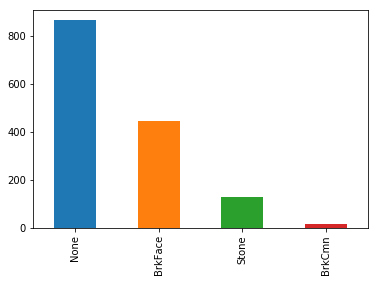

In [18]:
train_set.MasVnrType.value_counts().plot(kind='bar');

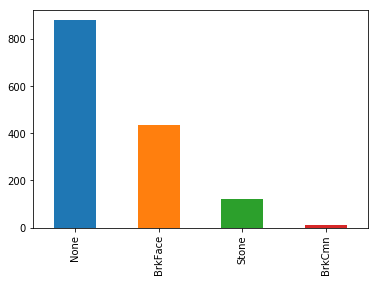

In [19]:
test_set.MasVnrType.value_counts().plot(kind='bar');

Нека погледнем как стоят нещата спрямо колоната, която трябва да предсказваме - ***SalePrice*** и да видим дали не можем да вземем решение за попълването ѝ.

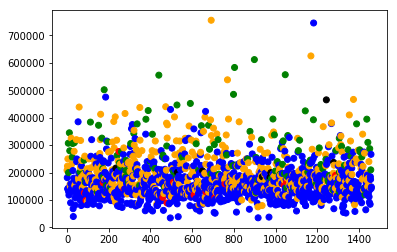

In [20]:
color_map = {'None': 'Blue', 'BrkFace': 'Orange', 'Stone': 'Green', 'BrkCmn': 'Red', 'NA': 'Black'}
colors = [color_map[point] for point in train_set.MasVnrType.fillna('NA')]
plt.scatter(x=range(0, len(colors)), y=train_set.SalePrice, c=colors)
del color_map, colors

Не се вижда лесно спрямо коя група липсващите са по-близки. Нека разлгедаме отделни графики.

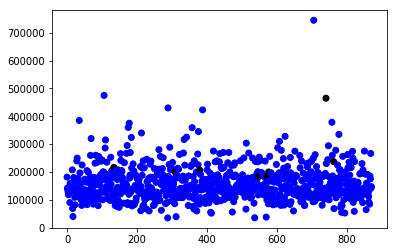

In [21]:
color_map = {'None': 'Blue', 'NA': 'Black'}
indexes = train_set.MasVnrType[(train_set.MasVnrType.isnull() | (train_set.MasVnrType == 'None'))].index
points = train_set.MasVnrType[indexes].fillna('NA')
colors = [color_map[point] for point in points]
plt.scatter(x=range(0, len(colors)), y=train_set.SalePrice[indexes], c=colors)
del color_map, indexes, colors, points

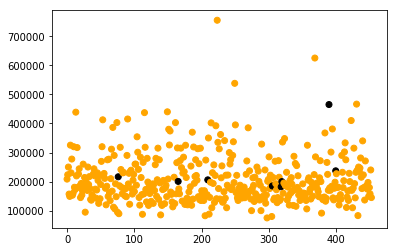

In [22]:
color_map = {'BrkFace': 'Orange', 'NA': 'Black'}
indexes = train_set.MasVnrType[(train_set.MasVnrType.isnull() | (train_set.MasVnrType == 'BrkFace'))].index
points = train_set.MasVnrType[indexes].fillna('NA')
colors = [color_map[point] for point in points]
plt.scatter(x=range(0, len(colors)), y=train_set.SalePrice[indexes], c=colors)
del color_map, indexes, colors, points

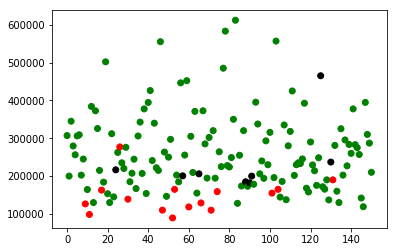

In [23]:
color_map = {'Stone': 'Green', 'BrkCmn': 'Red', 'NA': 'Black'}
indexes = train_set.MasVnrType[train_set.MasVnrType.isnull() | (train_set.MasVnrType == 'Stone') | (train_set.MasVnrType == 'BrkCmn')].index
points = train_set.MasVnrType[indexes].fillna('NA')
colors = [color_map[point] for point in points]
plt.scatter(x=range(0, len(colors)), y=train_set.SalePrice[indexes], c=colors)
del color_map, indexes, colors, points

Нека разгледаме и статистическа информация!

In [24]:
train_set.SalePrice[train_set.MasVnrType.isnull()].describe()

count         8.000000
mean     236484.250000
std       93964.474968
min      182000.000000
25%      196150.000000
50%      203287.000000
75%      221625.000000
max      465000.000000
Name: SalePrice, dtype: float64

In [25]:
train_set.SalePrice[train_set.MasVnrType == 'None'].describe()

count       864.000000
mean     156221.891204
std       60708.262798
min       34900.000000
25%      118991.000000
50%      143000.000000
75%      181875.000000
max      745000.000000
Name: SalePrice, dtype: float64

In [26]:
train_set.SalePrice[train_set.MasVnrType == 'BrkFace'].describe()

count       445.000000
mean     204691.871910
std       81214.293554
min       75000.000000
25%      149300.000000
50%      181000.000000
75%      236000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [27]:
train_set.SalePrice[train_set.MasVnrType == 'Stone'].describe()

count       128.000000
mean     265583.625000
std       99940.156577
min      119000.000000
25%      194650.000000
50%      246839.000000
75%      312779.000000
max      611657.000000
Name: SalePrice, dtype: float64

Изглежда сякаш липсващата група е най-близка до ***Stone*** групата, разбира се няма как да знаем, че това е в сила за test set-a. Но там липсва информация в малко над 1% от данните, което не е чак толкова. За това ще предположим, че липсващите данни са от тази група и ще попълним данните. Ако не сме доволни от крайния резултат можем да пробваме нещо друго, но за сега ще пробваме с това.

Нека видим средната стойност за двата set-а.

In [28]:
train_set.MasVnrArea[train_set.MasVnrType == 'Stone'].mean(), test_set.MasVnrArea[test_set.MasVnrType == 'Stone'].mean()

(239.3046875, 239.8099173553719)

Двете са много близки числа, така че ще попълним всеки от двата set-а с неговата.

In [29]:
def fill_missing_for_masvnr(set_to_fill):
    set_to_fill.MasVnrType = set_to_fill.MasVnrType.fillna('Stone')
    set_to_fill.MasVnrArea = set_to_fill.MasVnrArea.fillna(set_to_fill.MasVnrArea[set_to_fill.MasVnrType == 'Stone'].mean())
    return set_to_fill

In [30]:
train_set = fill_missing_for_masvnr(train_set)
test_set = fill_missing_for_masvnr(test_set)

Нека си припомним каква информация липсва.

In [31]:
missing(train_set)

,Total Missing,Percentage of Missing
LotFrontage,259,0.177397
Electrical,1,0.000685


In [32]:
missing(test_set)

,Total Missing,Percentage of Missing
LotFrontage,227,0.155586
MSZoning,4,0.002742
Functional,2,0.001371
Utilities,2,0.001371
KitchenQual,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
SaleType,1,0.000685


Ще попълним стойността на реда за който липсва информация в колоната ***Electrical***

Нека видим как стоят нещата в тази колона, от описанието се вижда,че тя е категорийна.

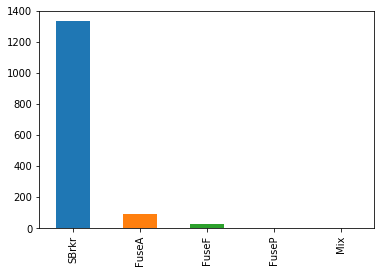

In [33]:
train_set.Electrical.value_counts().plot(kind='bar');

Напрактика няма голямо значение за това ще я попълним с доминантната стойност.

In [34]:
train_set.Electrical = train_set.Electrical.fillna('SBrkr')

И така до тук липсва информация за:

In [35]:
missing(train_set)

,Total Missing,Percentage of Missing
LotFrontage,259,0.177397


In [36]:
missing(test_set)

,Total Missing,Percentage of Missing
LotFrontage,227,0.155586
MSZoning,4,0.002742
Functional,2,0.001371
Utilities,2,0.001371
KitchenQual,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685
SaleType,1,0.000685


В не малка част от данните липсва информация в колоната ***LotFrontage***, така че за момента ще я премахнем от данните и ако не сме доволни от крайния резултат бихме могли да я попълним със средна стойност, занулим или дори да пробваме да я предскажем. Но за сега ще я пренебрегнем!

In [37]:
def drop_lot_frontage_column(set_to_drop_from):
    return set_to_drop_from.drop(labels=['LotFrontage'], axis=1)

In [38]:
train_set = drop_lot_frontage_column(train_set)
test_set = drop_lot_frontage_column(test_set)

Вече нямаме липсваща информация в train set-а, но все още има липсваща информация в test set-a.

In [39]:
missing(train_set)

,Total Missing,Percentage of Missing


In [40]:
missing(test_set)

,Total Missing,Percentage of Missing
MSZoning,4,0.002742
Utilities,2,0.001371
Functional,2,0.001371
SaleType,1,0.000685
KitchenQual,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685


Остава да попълним и всички останали липсващи данни. Това ще направим по следния начин:

- Ако колоната е числова, то ще попълним липсващите в колоната с медианата.
- Ако колоната е категорийна, то ще попълним липсващите в колоната с модата.

Но преди това ще разделим колоните на числови и категорийни.

In [41]:
categorial_columns = test_set.select_dtypes(include = ["object"]).columns
numeric_columns = test_set.select_dtypes(exclude = ["object"]).columns

Сега ще попълним данните липсващи в числовите колони.

In [42]:
def fillna_numeric_columns(set_to_fill, numeric_columns):
    for col in numeric_columns:
        set_to_fill[col] = set_to_fill[col].mean()
    return set_to_fill

In [43]:
test_set = fillna_numeric_columns(test_set, numeric_columns)

Нека видим дали сме попълнили някоя колона:

In [44]:
missing(test_set)

,Total Missing,Percentage of Missing
MSZoning,4,0.002742
Utilities,2,0.001371
Functional,2,0.001371
SaleType,1,0.000685
KitchenQual,1,0.000685
Exterior1st,1,0.000685
Exterior2nd,1,0.000685


Явно не сме :(

In [45]:
def encode_categorical(data, columns, encoders):
    data = data.fillna('')
    return pd.DataFrame({col: encoders[col].transform(data[col]) for col in columns}, index = data.index)

def fill_missing_from_categorical(data, columns, encoders):
    for col in columns:
        if '' in encoders[col].classes_:
            mapped_na = (encoders[col].transform(['']))[0]
            data.loc[data[data[col] == mapped_na].index, col] = int(data[col][data[col] != mapped_na].mode())
    return data

def decode_categorical(data, columns, encoders):
    return pd.DataFrame({col: encoders[col].inverse_transform(data[col]) for col in columns}, index = data.index)

def fillna_catecorial_columns(data, columns):
    encoders = {col: LabelEncoder().fit(pd.concat([train_set[col], test_set[col].fillna('')])) for col in categorial_columns}
    return decode_categorical(fill_missing_from_categorical(encode_categorical(data, columns, encoders), columns, encoders), columns, encoders)

In [46]:
test_set = fillna_catecorial_columns(test_set, categorial_columns)

Нека се уверим, че вече нямаме липсващи данни:

In [47]:
missing(train_set)

,Total Missing,Percentage of Missing


In [48]:
missing(test_set)

,Total Missing,Percentage of Missing


In [49]:
def one_hot_encode_categorical(data, train, test, categorial_columns):
    one_hot_encoder = OneHotEncoder().fit(data[categorial_columns])
    return one_hot_encoder.transform(train[categorial_columns]), one_hot_encoder.transform(test[categorial_columns])

def map_predicrted(pred, y_mean):
    pred[(pred == 0.0) | (pred == inf)] = y_mean
    return pred

def best_score_of_LR(train):
    X, y = train.drop(labels=['SalePrice'], axis=1), train.SalePrice
    y_mean = float(y.mean())
    categorial_columns = X.select_dtypes(include = ["object"]).columns
    numeric_columns = X.select_dtypes(exclude = ["object"]).columns    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    one_hot_x_train, one_hot_x_test = one_hot_encode_categorical(X, x_train, x_test, categorial_columns)
    new_x_train = pd.np.concatenate([one_hot_x_train.todense(), x_train[numeric_columns]], axis=1)
    new_x_test = pd.np.concatenate([one_hot_x_test.todense(), x_test[numeric_columns]], axis=1)
    a = None
    reg = LinearRegression().fit(new_x_train, pd.np.log10(y_train))
    max_train_score = r2_score(10**reg.predict(new_x_train), y_train)
    max_test_score = r2_score(map_predicrted(10**reg.predict(new_x_test), y_mean), y_test)
    for r in np.linspace(0.01, 10, 100):
        ridge = Ridge(alpha=0.6).fit(new_x_train, pd.np.log10(y_train))
        score = r2_score(10**ridge.predict(new_x_test), y_test)
        if score > max_test_score:
            a = r
            max_test_score = score
            max_train_score = r2_score(10**ridge.predict(new_x_train), y_train)
    return a, max_train_score, max_test_score

In [50]:
best_score_of_LR(train_set)

/home/ivo/ML/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power


(0.01, 0.9289098100241773, 0.9156325624853473)

Нека премахнем outlier-ите от train set-a

In [51]:
def cor_matrix(data):
    corrmat = data.corr()
    sns.heatmap(corrmat, vmax=.8, square=True);
    cols = corrmat.nlargest(10, 'SalePrice')['SalePrice'].index
    cm = np.corrcoef(data[cols].values.T)
    hm = sns.heatmap(cm, square=True, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
    return cols[1:], cm[0]

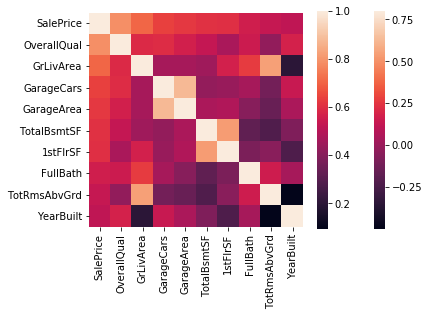

In [52]:
cols, cor = cor_matrix(train_set)

In [53]:
cor

array([1.        , 0.7909816 , 0.70862448, 0.6404092 , 0.62343144,
       0.60948567, 0.60585218, 0.56066376, 0.53372316, 0.52289733])

Нека видим малко графики:

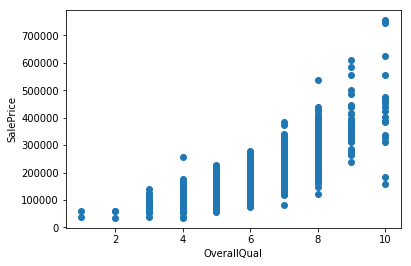

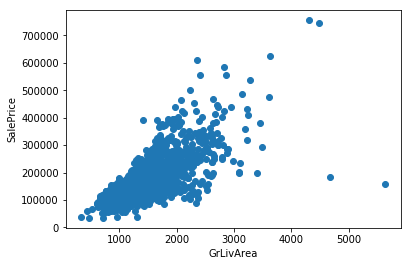

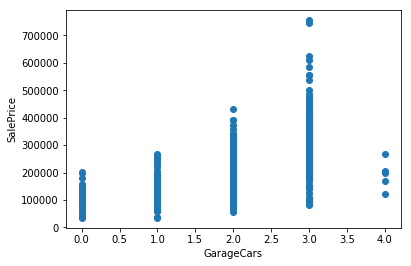

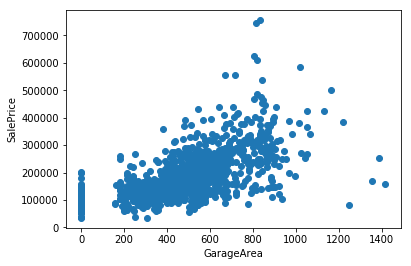

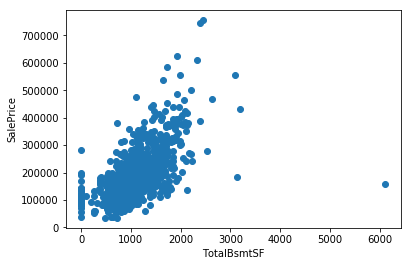

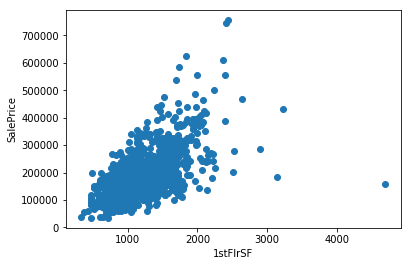

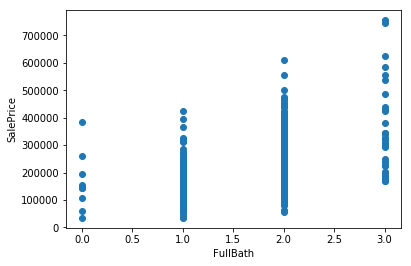

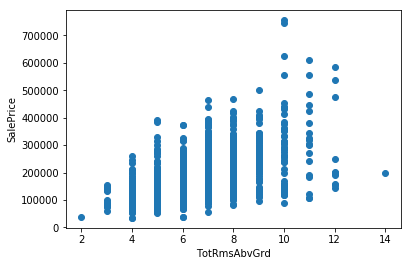

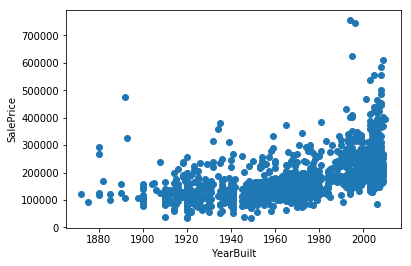

In [54]:
for col in cols:
    plt.scatter(train_set[col], train_set.SalePrice)
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()

In [55]:
train_set.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [56]:
def drop_outliers(train_set):
    train_set = train_set.drop(index=train_set[(train_set.GrLivArea > 4000) & (train_set.SalePrice < 300000)].index)
    train_set = train_set.drop(index=train_set[train_set.TotalBsmtSF > 6000].index)
    train_set = train_set.drop(index=train_set[train_set.TotRmsAbvGrd > 13].index)
    train_set = train_set.drop(index=train_set[train_set.GarageArea > 1230].index)
    return train_set

In [57]:
train_set = drop_outliers(train_set)

Нека видим графиките след премахването

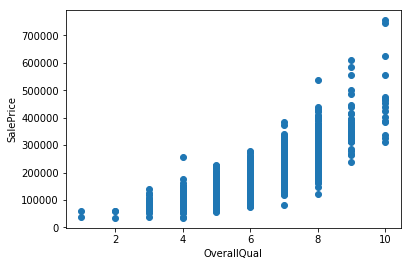

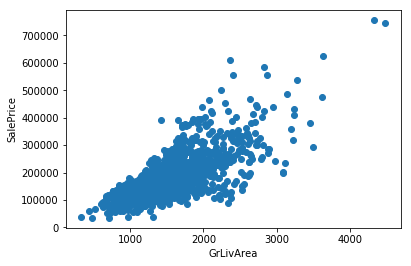

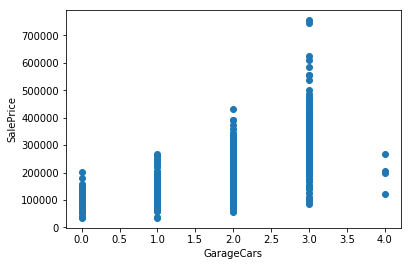

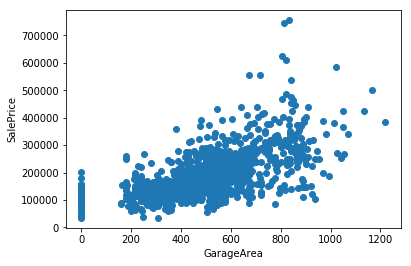

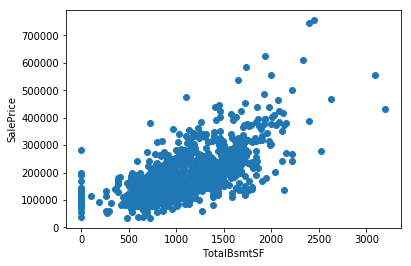

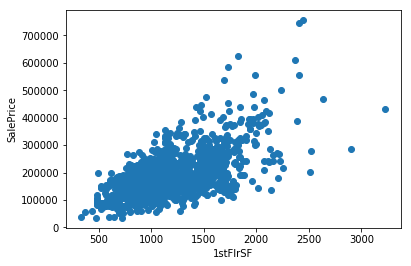

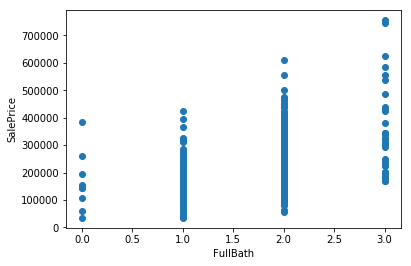

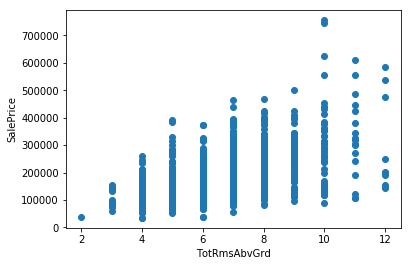

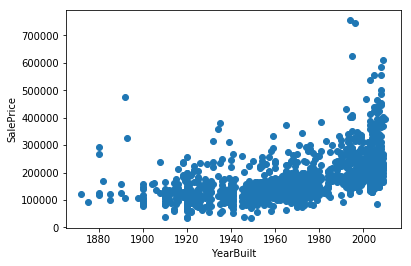

In [58]:
for col in cols:
    plt.scatter(train_set[col], train_set.SalePrice)
    plt.xlabel(col)
    plt.ylabel('SalePrice')
    plt.show()

In [59]:
best_score_of_LR(train_set)

/home/ivo/ML/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in power


(0.01, 0.9583079008031863, 0.9279185211320264)

И с този модел подобрихме и двата r2score-а от лекции :) Но има какво още да се желае